# 推理与验证

在训练神经网络之后，你现在可以使用它来进行预测。这种步骤通常被称作**推理**，这是一个借自统计学的术语。然而，神经网络在面对训练数据时往往表现得*太过优异*，因而无法泛化未见过的数据。这种现象被称作**过拟合**，它损害了推理性能。为了在训练时检测过拟合，我们测量并不在名为**验证集**的训练集中数据的性能。在训练时，我们一边监控验证性能，一边进行正则化，如 Dropout，以此来避免过拟合。在这个 notebook 中，我将向你展示如何在 PyTorch 中做到这一点。

首先，我会实现我自己的前馈神经网络，这个网络基于第四部分的练习中的 Fashion-MNIST 数据集构建。它是第四部分练习的解决方案，也是如何进行 Dropout 和验证的例子。

向往常一样，我们先通过 torchvision 来加载数据集。你将会在下一部分更深入地学习有关 torchvision 和加载数据的知识。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## 构建网络


跟 MNIST 数据集一样，Fashion-MNIST 数据集中每张图片的像素为 28x28，共 784 个数据点和 10 个类。我使用了 `nn.ModuleList` 来加入任意数量的隐藏层。这个模型中的 `hidden_layers` 参数为隐藏层大小的列表（以整数表示）。使用 `nn.ModuleList` 来寄存每一个隐藏模块，这样你可以在之后使用模块方法。

我还使用了 `forward` 方法来返回输出的 log-softmax。由于 softmax 是类的概率分布，因此 log-softmax 是一种对数概率，它有[许多优点](https://en.wikipedia.org/wiki/Log_probability)。使用这种对数概率，计算往往会更加迅速和准确。为了在之后获得类的概率，我将需要获得输出的指数（`torch.exp`）。

我们可以使用 [`nn.Dropout`](http://pytorch.org/docs/master/nn.html#dropout) 来在我们的网络中加入 Dropout。这与 `nn.Linear` 等其他模块的作用相似。它还将 Dropout 概率作为一种输入传递到网络中。

In [4]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability 丢弃的概率
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        # 这里不再手动设置 而是写成参数形式 传入
        # Add a variable number of more hidden layers  设置随机数量的隐藏层
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        # 扩展列表
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        # 丢弃模块 因为使用丢弃法dropout 这里drop_p作为网络的参数传入
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        # 使用log的softmax 获得更好的数字
        return F.log_softmax(x, dim=1)

# 训练网络

由于该模型的前向方法返回 log-softmax，因此我使用了[负对数损失](http://pytorch.org/docs/master/nn.html#nllloss) 作为标准。我还选用了[Adam 优化器](http://pytorch.org/docs/master/optim.html#torch.optim.Adam)。这是一种随机梯度下降的变体，包含了动量，并且训练速度往往比基本的 SGD 要快。

我还加入了一个代码块来测量验证损失和精确度。由于我在这个神经网络中使用了 Dropout，在推理时我需要将其关闭，否则这个网络将会由于许多连接的关闭而表现糟糕。在 PyTorch 中，你可以使用 `model.train()` 和 `model.eval()` 来将模型调整为“训练模式”或是“评估模式”。在训练模式中，Dropout 为开启状态，而在评估模式中，Dropout 为关闭状态。这还会影响到其他模块，包括那些应该在训练时开启、在推理时关闭的模块。

这段验证代码由一个通过验证集（并分裂成几个批次）的前向传播组成。我根据 log-softmax 输出来计算验证集的损失以及预测精确度。

In [7]:
# Create the network, define the criterion and optimizer
# 传入参数 784输入 10个输出 500个单元作为隐藏层 也可以传入一个列表[500, 200，xxx] 作为多层的单元
# 比如上面的[500,200,100]即有三个隐藏层 每层分别有500个单元200个单元100个单元...
# 丢弃的概率为0.5
model = Network(784, 10, [500], drop_p=0.5)
# 定义损失函数 负对数似然损失 对分类有效 
criterion = nn.NLLLoss()
# 使用Adam优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 输出model观察一下
model

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
  )
  (output): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)

In [8]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40
for e in range(epochs):
    # 模型在训练时 启用dropout
    model.train()
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        # Wrap images and labels in Variables so we can calculate gradients
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        
        output = model.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            # 模型在推理阶段 不能启用dropout
            model.eval() # 在评估阶段
            
            accuracy = 0
            test_loss = 0
            for ii, (images, labels) in enumerate(testloader):
                
                images = images.resize_(images.size()[0], 784)
                # 将volatile设为True 意味着不想进行反向传播遍历 因为在推理时 我们不需要用推理的
                # 数据将其也作为训练集 来反向传播并更新权重
                inputs = Variable(images, volatile=True)
                labels = Variable(labels, volatile=True)

                output = model.forward(inputs)
                test_loss += criterion(output, labels).data[0]
                
                ## Calculating the accuracy 
                # 模型输出的是log_softmax, 如果对其求对数即可获得各类之间的softmax概率分布
                ps = torch.exp(output).data
                # 测试标实际标签是否和预测的一样 这里的ps是概率分布 判断模型预测了对不对
                # 然后对其取最大值 即返回最大的概率 即最有可能的那个标签 的索引（取[1]
                equality = (labels.data == ps.max(1)[1])
                # 即网络所作的正确推理除以预测的总次数 可以是一堆0和1 我们取均值即可 
                # 真是1 假是0 正确了即1 错误了为0 那么整个准确率即为这个equality的均值
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # 要确保验证完之后将模型重置为训练模式
            model.train()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/2..  Training Loss: 1.040..  Test Loss: 0.711..  Test Accuracy: 0.739
Epoch: 1/2..  Training Loss: 0.697..  Test Loss: 0.627..  Test Accuracy: 0.763
Epoch: 1/2..  Training Loss: 0.668..  Test Loss: 0.620..  Test Accuracy: 0.758
Epoch: 1/2..  Training Loss: 0.617..  Test Loss: 0.552..  Test Accuracy: 0.798
Epoch: 1/2..  Training Loss: 0.608..  Test Loss: 0.558..  Test Accuracy: 0.800
Epoch: 1/2..  Training Loss: 0.573..  Test Loss: 0.518..  Test Accuracy: 0.807
Epoch: 1/2..  Training Loss: 0.558..  Test Loss: 0.515..  Test Accuracy: 0.808
Epoch: 1/2..  Training Loss: 0.527..  Test Loss: 0.503..  Test Accuracy: 0.809
Epoch: 1/2..  Training Loss: 0.528..  Test Loss: 0.541..  Test Accuracy: 0.796
Epoch: 1/2..  Training Loss: 0.533..  Test Loss: 0.490..  Test Accuracy: 0.819
Epoch: 1/2..  Training Loss: 0.497..  Test Loss: 0.483..  Test Accuracy: 0.822
Epoch: 1/2..  Training Loss: 0.503..  Test Loss: 0.469..  Test Accuracy: 0.828
Epoch: 1/2..  Training Loss: 0.532..  Test Loss: 0.4

## 推理

模型已经训练好了，我们现在可以使用它来进行推理。之前已经进行过这一步骤，但现在我们需要使用 `model.eval()` 来将模型设置为推理模式。

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':


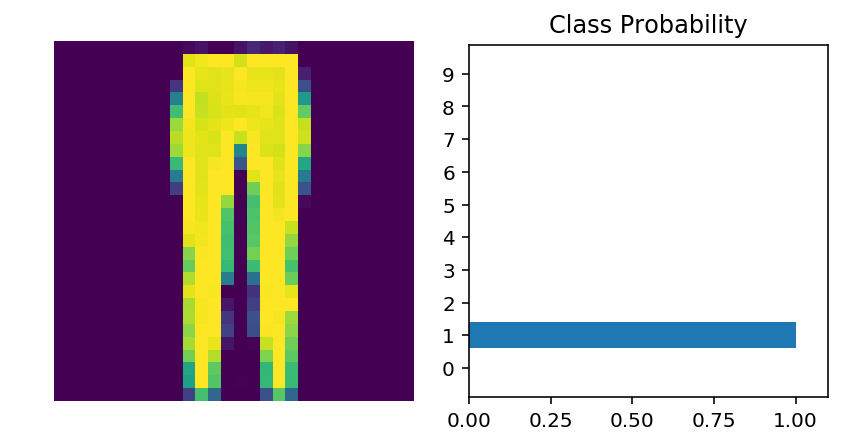

In [10]:
# Test out your network!
# 注意要设置成推理模式！！！
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Calculate the class probabilities (softmax) for img
output = model.forward(Variable(img, volatile=True))
ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps)

## 下一步！

在下一部分，我将为你展示如何保存训练好的模型。一般来说，你不会希望在每次使用模型时都要重新训练，而是希望在训练好模型之后将其保存，以便下次训练或推理时使用。